In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import re

from utils import (
    load_tfidf_classifier_model,
    load_embedding_svm_model,
    split_dataset,
    load_embedding_classifier_model
)

from modules.db import TeradataDatabase

from constants import (
    FULL_DATASET_PATH,
    FULL_TRAIN_DATASET_PATH,
    FULL_TEST_DATASET_PATH,
    FULL_EMBEDDING_MODEL_OUTPUT_DATASET_PATH,
    TFIDF_CLASSIFIER_CONFIG_PATH,
    EMBEDDING_SVM_CONFIG_PATH,
    ENSEMBLE_CONFIG_PATH,
    FULL_ENSEMBLE_MODEL_OUTPUT_DATASET_PATH,
    EMBEDDING_CLASSIFIER_CONFIG_PATH,
    FULL_TFIDF_SIMILARITY_OUTPUT_DATASET_PATH,
    CLASS_ONLY_CLASSIFIER
)

Logger initialized. All logs will be saved to: c:\Users\ss255385\OneDrive - Teradata Corporation\Desktop\Prodify-V2.0\logs\log.txt
[2025-09-17 13:39:20] - logger:_log - INFO - Logger initialized. Logs will be saved to c:\Users\ss255385\OneDrive - Teradata Corporation\Desktop\Prodify-V2.0\logs\log.txt


[2025-09-17 13:39:34] - pyplot:switch_backend - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2025-09-17 13:39:34] - pyplot:switch_backend - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2025-09-17 13:39:34] - font_manager:_findfont_cached - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2025-09-17 13:39:34] - font_manager:_findfont_cached - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\ss255385\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2025-09-17 13:39:34] - font_manager:_findfont_cached - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\ss255385\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf', name=

In [5]:
df_gpc = pd.read_csv(FULL_DATASET_PATH)
df_gpc.head()

Unnamed: 0                                       product_name  \
0           0                        Sterling Silver Angel Charm   
1           1                HP Pavilion xi . cm (�) IPS Monitor   
2           2  East Carolina Pirates Ladies Personalized Bask...   
3           3  Tekonsha  P Electric Brake Control, - Trailer ...   
4           4                  RN-XV WiFly Module - Wire Antenna   

                                         description               segment  \
0           This little angel charm is just heavenly  Personal Accessories   
1  Share photos, videos, and games with everyone ...             Computing   
2  Feel like a bona fide member of East Carolina ...              Clothing   
3  Receive free shipping on this item. Enter coup...            Automotive   
4  Description: The RN-XV module by Roving Networ...   Electrical Supplies   

                                   family  \
0                    Personal Accessories   
1                   Computers/Video Games   
2                                Clothing   
3  Automotive Accessories and Maintenance   
4     Electronic Communication Components   

                                 class brick     source  \
0                            Jewellery   NaN  MWPD_FULL   
1      Computer/Video Game Peripherals   NaN  MWPD_FULL   
2                 Upper Body Wear/Tops   NaN  MWPD_FULL   
3        Automotive Maintenance/Repair   NaN  MWPD_FULL   
4  Electronic Communication Components   NaN  MWPD_FULL   

                                                text  \
0                        sterling silver angel charm   
1                    hp pavilion xi . cm ips monitor   
2  east carolina pirates ladies personalized bask...   
3  tekonsha p electric brake control - trailer axles   
4                  rn-xv wifly module - wire antenna   

                                           dedup_key  
0                        sterling silver angel charm  
1                      hp pavilion xi cm ips monitor  
2  east carolina pirates ladies personalized bask...  
3    tekonsha p electric brake control trailer axles  
4                    rn xv wifly module wire antenna

In [6]:
split_dataset(FULL_DATASET_PATH, FULL_TRAIN_DATASET_PATH, FULL_TEST_DATASET_PATH)

In [3]:
def clean(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)

    return " ".join(text.strip().split())

In [4]:
df_train = pd.read_csv(FULL_TRAIN_DATASET_PATH)

df_train["product_name"] = df_train["product_name"].astype(str)

In [5]:
df_test = pd.read_csv(FULL_TEST_DATASET_PATH)

df_test["product_name"] = df_test["product_name"].astype(str)

In [10]:
X_train = df_train["product_name"].tolist()
y_train = df_train["class"].tolist()

In [11]:
X_test = df_test["product_name"].tolist()
segments = df_test["segment"].tolist()
families = df_test["family"].tolist()
classes = df_test["class"].tolist()

# TF-IDF with SVM

In [12]:
model = load_tfidf_classifier_model(TFIDF_CLASSIFIER_CONFIG_PATH)

In [13]:
model.fit(X_train, y_train)

In [15]:
y_pred = model.predict(X_test)

In [16]:
class_to_segment = df_train.set_index("class")["segment"].to_dict()
class_to_family = df_train.set_index("class")["family"].to_dict()

pred_segments = [class_to_segment.get(c, None) for c in y_pred]
pred_families = [class_to_family.get(c, None) for c in y_pred]

In [17]:
accuracy_score(segments, pred_segments)

0.9667695540815656

In [18]:
accuracy_score(families, pred_families)

0.9502200039403691

In [19]:
accuracy_score(classes, y_pred)

0.9431930124121626

In [20]:
model.save()

# Embedding With SVM

In [7]:
model = load_embedding_svm_model(EMBEDDING_SVM_CONFIG_PATH)

In [8]:
model.fit(X_train, y_train)

Batches:   0%|          | 0/1904 [00:00<?, ?it/s]

In [9]:
y_pred = model.predict(X_test)

Batches:   0%|          | 0/476 [00:00<?, ?it/s]

In [10]:
pred_segments = [pred[0] for pred in y_pred]
pred_families = [pred[1] for pred in y_pred]
pred_classes = [pred[2] for pred in y_pred]

In [11]:
accuracy_score(segments, pred_segments)

0.9326241134751773

In [12]:
accuracy_score(families, pred_families)

0.9061597058050959

In [13]:
accuracy_score(classes, pred_classes)

0.8815996847911741

In [ ]:
model.save()

# Embedding model

In [ ]:
embed_clf = load_embedding_classifier_model(EMBEDDING_CLASSIFIER_CONFIG_PATH)

In [ ]:
df = pd.read_csv(FULL_EMBEDDING_MODEL_OUTPUT_DATASET_PATH)

In [5]:
df["pred_segment"] = df["pred_segment"].apply(clean)
df["pred_family"] = df["pred_family"].apply(clean)
df["pred_class"] = df["pred_class"].apply(clean)

In [6]:
accuracy_score(df["segment"].tolist(), df["pred_segment"].tolist())

0.3044391909640137

In [7]:
accuracy_score(df["family"].tolist(), df["pred_family"].tolist())

0.11583924349881797

In [8]:
accuracy_score(df["class"], df["pred_class"])

0.050170738114000524

## Test TF-IDF Similiraity

In [2]:
results = pd.read_csv(FULL_TFIDF_SIMILARITY_OUTPUT_DATASET_PATH)

In [3]:
accuracy_score(results["segment"], results["pred_segment"])

0.3619885729296644

In [4]:
accuracy_score(results["family"], results["pred_family"])

0.16050436724239836

In [5]:
accuracy_score(results["class"], results["pred_class"])

0.10829447691600447

# Test Ensemble Pipeline

In [2]:
df = pd.read_csv(FULL_ENSEMBLE_MODEL_OUTPUT_DATASET_PATH)

In [3]:
accuracy_score(df["segment"].tolist(), df["pred_segment"].tolist())

0.9583661675860258

In [4]:
accuracy_score(df["family"].tolist(), df["pred_family"].tolist())

0.9506829524560021

In [5]:
accuracy_score(df["class"], df["pred_class"])

0.9359075387444181

# Perofarmance Results

In [2]:
tfidf_simliraity_results = pd.read_csv(FULL_TFIDF_SIMILARITY_OUTPUT_DATASET_PATH)

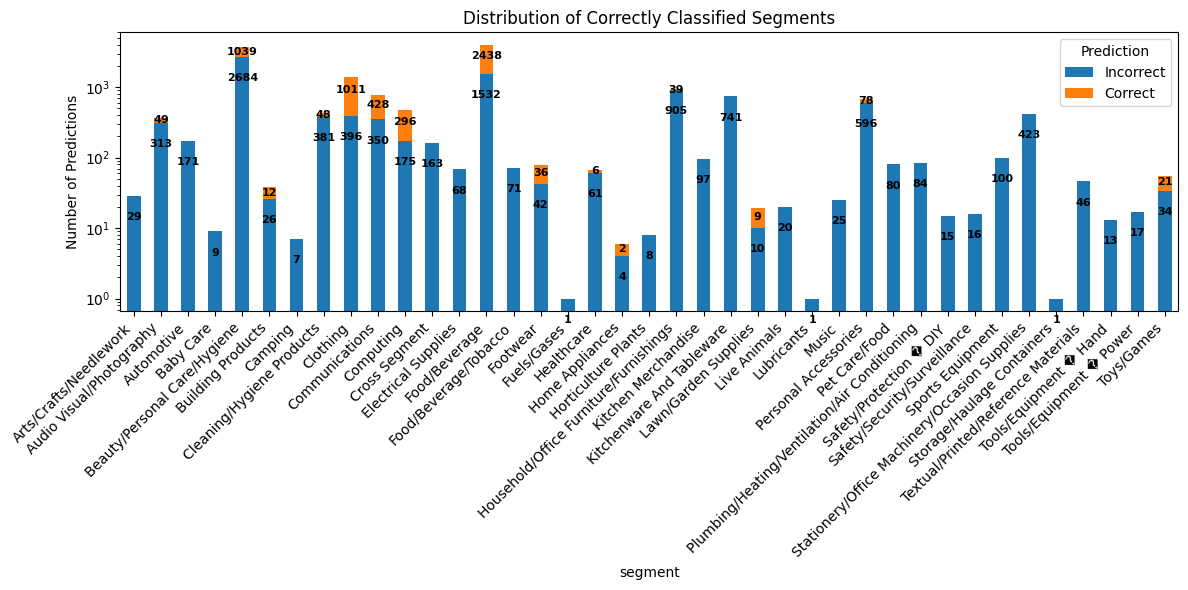

In [14]:
tfidf_simliraity_results["correct_segment"] = (
    tfidf_simliraity_results["segment"] == tfidf_simliraity_results["pred_segment"]
)

counts = (
    tfidf_simliraity_results.groupby(["segment", "correct_segment"])
    .size()
    .unstack(fill_value=0)
)

ax = counts.plot(kind="bar", stacked=True, figsize=(12, 6))
ax.set_ylabel("Number of Predictions")
ax.set_title("Distribution of Correctly Classified Segments")
ax.legend(["Incorrect", "Correct"], title="Prediction")
plt.xticks(rotation=45, ha="right")

ax.set_yscale("log")

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(
            x + width / 2,
            y + height / 2,
            f"{int(height)}",
            ha="center",
            va="center",
            fontsize=8,
            color="black",
            weight="bold",
        )

plt.tight_layout()
plt.show()


In [ ]:
tfidf_simliraity_results["correct_family"] = (
    tfidf_simliraity_results["family"] == tfidf_simliraity_results["pred_family"]
)

counts = tfidf_simliraity_results.groupby(["family", "correct_family"]).size().unstack(fill_value=0)

ax = counts.plot(kind="bar", stacked=True, figsize=(10, 6))
ax.set_ylabel("Number of Predictions")
ax.set_title("Distribution of Correctly Classified Families")
ax.legend(["Incorrect", "Correct"], title="Prediction")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
tfidf_simliraity_results["correct_class"] = (
    tfidf_simliraity_results["class"] == tfidf_simliraity_results["pred_class"]
)

counts = tfidf_simliraity_results.groupby(["class", "correct_class"]).size().unstack(fill_value=0)

ax = counts.plot(kind="bar", stacked=True, figsize=(10, 6))
ax.set_ylabel("Number of Predictions")
ax.set_title("Distribution of Correctly Classified Classes")
ax.legend(["Incorrect", "Correct"], title="Prediction")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [4]:
classifier_results = pd.read_csv(CLASS_ONLY_CLASSIFIER)

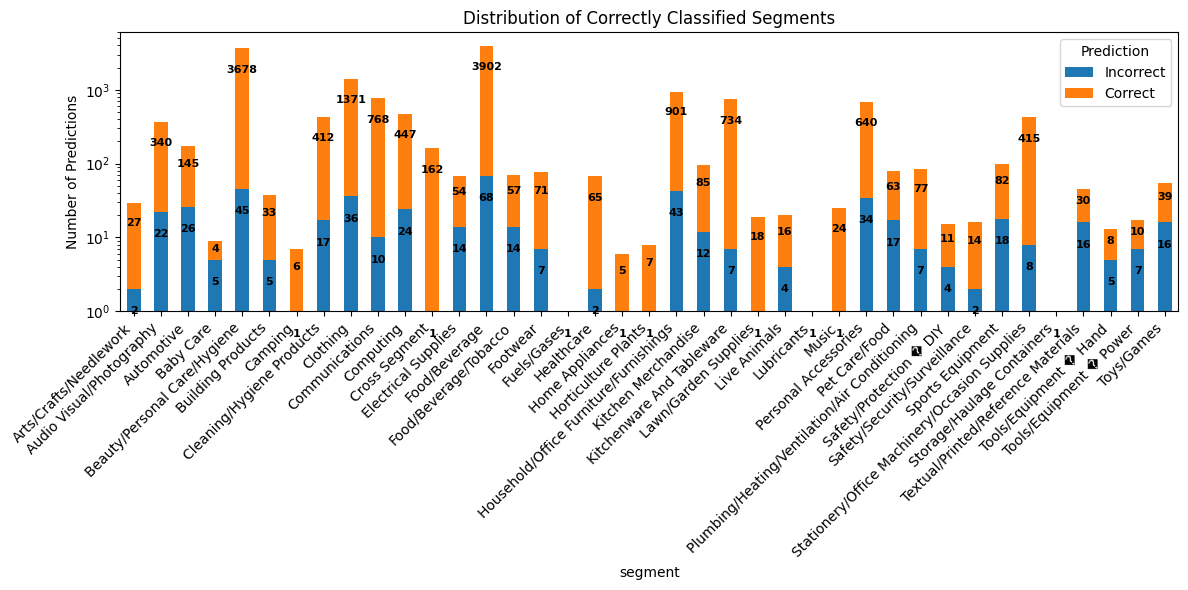

In [ ]:
classifier_results["correct_segment"] = (
    classifier_results["segment"] == classifier_results["pred_segment"]
)

counts = (
    classifier_results.groupby(["segment", "correct_segment"])
    .size()
    .unstack(fill_value=0)
)

ax = counts.plot(kind="bar", stacked=True, figsize=(12, 6))
ax.set_ylabel("Number of Predictions")
ax.set_title("Distribution of Correctly Classified Segments")
ax.legend(["Incorrect", "Correct"], title="Prediction")
plt.xticks(rotation=45, ha="right")

ax.set_yscale("log")

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(
            x + width / 2,
            y + height / 2,
            f"{int(height)}",
            ha="center",
            va="center",
            fontsize=8,
            color="black",
            weight="bold",
        )

plt.tight_layout()
plt.show()

In [ ]:
classifier_results["correct_family"] = (
    classifier_results["family"] == classifier_results["pred_family"]
)

counts = classifier_results.groupby(["family", "correct_family"]).size().unstack(fill_value=0)

ax = counts.plot(kind="bar", stacked=True, figsize=(10, 6))
ax.set_ylabel("Number of Predictions")
ax.set_title("Distribution of Correctly Classified Families")
ax.legend(["Incorrect", "Correct"], title="Prediction")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
classifier_results["correct_class"] = (
    classifier_results["class"] == classifier_results["pred_class"]
)

counts = classifier_results.groupby(["class", "correct_class"]).size().unstack(fill_value=0)

ax = counts.plot(kind="bar", stacked=True, figsize=(10, 6))
ax.set_ylabel("Number of Predictions")
ax.set_title("Distribution of Correctly Classified Classes")
ax.legend(["Incorrect", "Correct"], title="Prediction")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()